Epoch 1/150, Loss: 322385416.0
Epoch 11/150, Loss: 103292303.79104477
Epoch 21/150, Loss: 51105721.79104478
Epoch 31/150, Loss: 35529406.3880597
Epoch 41/150, Loss: 33385072.365671642
Epoch 51/150, Loss: 31408796.029850747
Epoch 61/150, Loss: 29236000.492537312
Epoch 71/150, Loss: 27409978.85074627
Epoch 81/150, Loss: 25941977.94402985
Epoch 91/150, Loss: 24852878.458955225
Epoch 101/150, Loss: 24063392.5130597
Epoch 111/150, Loss: 23561620.14552239
Epoch 121/150, Loss: 23207347.260261193
Epoch 131/150, Loss: 22880078.47574627
Epoch 141/150, Loss: 22715964.972014926


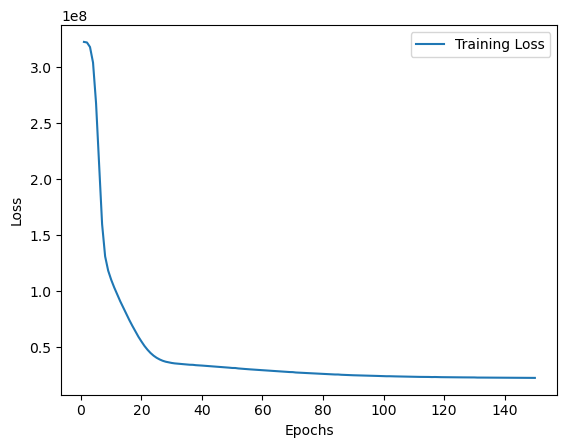

R-squared: 0.8765598188885912


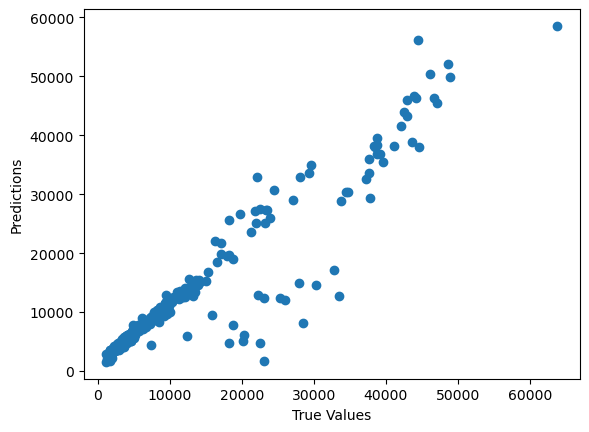

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Загрузка данных
data = pd.read_csv("insurance.csv")
input_size = 6

# Разделение данных на признаки и целевую переменную
X = data.drop(columns=['charges'])
y = data['charges']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем списки категориальных и числовых признаков
categorical_features = ['sex', 'smoker', 'region']
numerical_features = list(set(X.columns) - set(categorical_features))

# Создаем трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создаем класс, который будет определять арихитектуру НС
class InsuranceModel(nn.Module):
    def __init__(self, input_size):
        super(InsuranceModel, self).__init__()
        self.fc1 = nn.Linear(11, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Получаем количество признаков после применения преобразования
input_size = X_train.shape[1]

# Создаем модель и проводим предобработку данных
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', InsuranceModel(input_size=input_size))
])

model.named_steps['preprocessor'].fit(X_train)

# Определяем фунцию потерь
criterion = nn.MSELoss()
optimizer = optim.Adam(model.named_steps['regressor'].parameters(), lr=0.0005)

# Преобразование целевой переменной в тензор
y_train_tensor = torch.FloatTensor(y_train.values)

# Преобразование входных данных в тензор
X_train_tensor = torch.FloatTensor(np.array(model.named_steps['preprocessor'].transform(X_train)))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Задаем количество эпох
num_epochs = 150
train_losses = []

# Обучаем нашу модель
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model.named_steps['regressor'](inputs)

        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # При каждой 10 эпохе будем выводить значение функции потерь
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')


# Выведем график обучения (фуннкция потерь/эпоха)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.named_steps['regressor'].eval()

X_test_tensor = torch.FloatTensor(np.array(model.named_steps['preprocessor'].transform(X_test)))

# Проверяем наши значения на тестовой выборке
with torch.no_grad():
    y_pred = model.named_steps['regressor'](X_test_tensor).squeeze().numpy()

# Для полученных значений вычисляем коэффициент детерминации
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

# И создаем график оценки эффективности обучения модели (реальные значения/прогнозы)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# Сохраняем веса модели в файл
torch.save(model.named_steps['regressor'].state_dict(), 'insurance_model.pth')
# Сохраненяем в файл предварительно обученный трансформатор
torch.save(preprocessor, 'preprocessor.pth')
